<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

#### import the packages

In [5]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

#### data import

In [6]:
# import the data under consideration
bankloans = pd.read_csv('bankloans.csv')

#### UDFs

In [7]:
def continuous_var_summary( x ):
    
    # freq and missings
    n_total = x.shape[0]
    n_miss = x.isna().sum()
    perc_miss = n_miss * 100 / n_total
    
    # outliers - iqr
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lc_iqr = q1 - 1.5 * iqr
    uc_iqr = q3 + 1.5 * iqr
    
    
    return pd.Series( [ x.dtype, x.nunique(), n_total, x.count(), n_miss, perc_miss,
                       x.sum(), x.mean(), x.std(), x.var(), 
                       lc_iqr, uc_iqr, 
                       x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.10), 
                       x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), 
                       x.quantile(0.90), x.quantile(0.95), x.quantile(0.99), x.max() ], 
                     
                    index = ['dtype', 'cardinality', 'n_tot', 'n', 'nmiss', 'perc_miss',
                             'sum', 'mean', 'std', 'var',
                        'lc_iqr', 'uc_iqr',
                        'min', 'p1', 'p5', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95', 'p99', 'max']) 

In [9]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

#### data inspection

In [10]:
# check the metadata
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       850 non-null    int64  
 1   ed        850 non-null    int64  
 2   employ    850 non-null    int64  
 3   address   850 non-null    int64  
 4   income    850 non-null    int64  
 5   debtinc   850 non-null    float64
 6   creddebt  850 non-null    float64
 7   othdebt   850 non-null    float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB


In [15]:
bankloans.default.count()

700

In [16]:
# get the cardinality
print( 'cardinality', bankloans.default.nunique() )

# get the %age of each class
print( bankloans.default.value_counts() / bankloans.default.count() )

cardinality 2
0.0    0.738571
1.0    0.261429
Name: default, dtype: float64


if data is imbalanced (class %age is less than 20% use either the undersampling / oversampling technique)

In [ ]:
# which customer has more probabilty of making a default on loan

Salary:                            Debt:
-----------------                  ------------------
C1 - 5 LPA                         3.5 L
C2 - 15 LPA                        20 L
C3 - 50 LPA                        45 L


In [17]:
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


#### seperate out the data for existing and the new customers

In [18]:
# separate the new and existing customers
bankloans_existing = bankloans.loc[ bankloans.default.notna() ]
bankloans_new = bankloans.loc[ bankloans.default.isna() ]

In [19]:
bankloans_existing.shape

(700, 9)

In [21]:
# EDA for all the variables
bankloans_existing.apply( continuous_var_summary )

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
dtype,int64,int64,int64,int64,int64,float64,float64,float64,float64
cardinality,37,5,32,31,114,231,695,699,2
n_tot,700,700,700,700,700,700,700,700,700
n,700,700,700,700,700,700,700,700,700
nmiss,0,0,0,0,0,0,0,0,0
perc_miss,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum,24402,1206,5872,5795,31921,7182.4,1087.486972,2140.746028,183.0
mean,34.86,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
var,63.957482,0.861566,44.329483,46.578939,1355.287265,46.611118,4.482523,10.808015,0.19336


#### data prepration/data cleaning

In [22]:
# outlier treatment
bankloans_existing = bankloans_existing.apply( lambda x: x.clip(lower = x.quantile(0.01), 
                                                                upper = x.quantile(0.99)) )

In [17]:
# Handling missings
# bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

#### bi variate analysis to identify corr 

In [23]:
# correlation matrix
corr_matrix = bankloans_existing.corr()
# corr_matrix.to_csv('corr.csv')

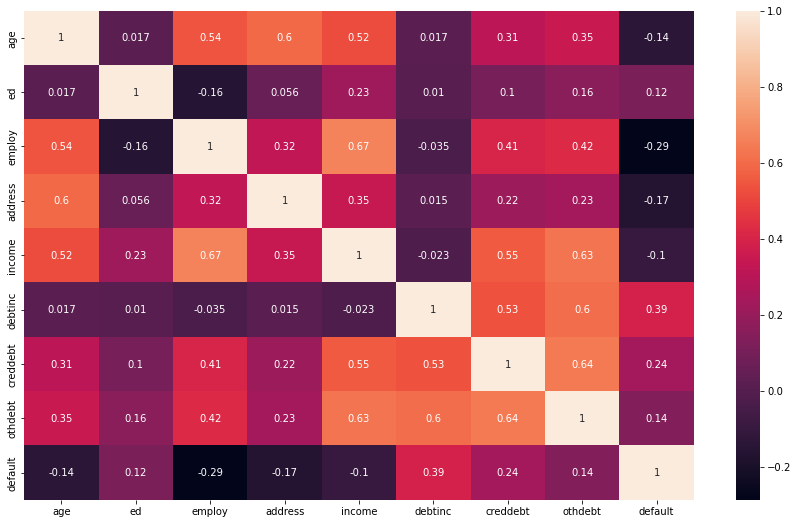

In [24]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (15, 9))
sns.heatmap(bankloans_existing.corr(), annot = True)
plt.show()

### Building logistic Regression Model

In [25]:
# Train and Test split
train, test = train_test_split( bankloans_existing, test_size = 0.3, random_state =  42 )

In [26]:
# print the columns
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

#### Model 1 - with all the features

In [27]:
model_eq = 'default ~ ' + ' + '.join( train.columns.difference(['default']) )
model_eq

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [28]:
# execute a model for the X variables
m1 = smf.logit( formula = model_eq, data = train ).fit() 

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


In [32]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.275     
Dependent Variable: default          AIC:              434.8834  
Date:               2022-08-28 10:49 BIC:              472.6330  
No. Observations:   490              Log-Likelihood:   -208.44   
Df Model:           8                LL-Null:          -287.47   
Df Residuals:       481              LLR p-value:      4.0651e-30
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.3844    0.7360  -1.8808  0.0600  -2.8270   0.0582
address       -0.0853    0.0258  -3.3063  0.0009  -0.1359  -0.0348
age            0.0389    0.0202   1.9237  0.0544  -0.0007   0.0784
creddebt       0.6410    0.138

#### Data Exploratory Analysis
    - Variable Reduction using Somer's D values
    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

#### get the Somer's D values for all the X variables

In [40]:
# perform the bi-variate logictic regression of all X variables

# declare an empty dataframe
somarsd_score = pd.DataFrame()

# iterate for all variable names
for var_name in bankloans_existing.columns.difference(['default']):
    
    # build and fit the model taking one X at a time
    log_mod = smf.logit( formula = 'default ~ ' + var_name, data = bankloans_existing ).fit()
    
    # predict the y
    y_predicted_proba = log_mod.predict( bankloans_existing )
    
    # get the roc_auc_score
    concordance = roc_auc_score( bankloans_existing.default, y_predicted_proba )
    
    # get the Somars'd score
    somars_d = 2 * concordance - 1
    
    # save it in a temp dataframe
    temp_data = pd.DataFrame([var_name, concordance, somars_d]).T
    
    # save the record permanently in the output dataframe
    somarsd_score = pd.concat( [somarsd_score, temp_data], axis = 0 )

# add the column names
somarsd_score.columns = ['variable', 'roc_auc_score', 'somars_d']

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [43]:
# display the output
features = list( somarsd_score.loc[ somarsd_score.somars_d >= 0.2, 'variable' ])
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

#### VIF - Variance Inflation Factor

In [44]:
# run the dmatrices
equation = 'default ~ ' + ' + '.join( features)

a, b = dmatrices( equation, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["features"] = b.columns
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]

vif

,features,VIF Factor
0,Intercept,28.286222
1,address,1.559236
2,age,2.036933
3,creddebt,2.564921
4,debtinc,1.778339
5,employ,1.997947
6,income,2.601717


### Build the actual model

#### Model 2 - after performing the signifance and multi-colinearity check

In [47]:
features

['address', 'age', 'creddebt', 'debtinc', 'employ', 'income']

In [50]:
model_eq = 'default ~ ' + ' + '.join( features )
m2 = smf.logit( model_eq, data = train ).fit()
print( m2.summary2() )

Optimization terminated successfully.
         Current function value: 0.426980
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              432.4402  
Date:               2022-08-28 11:18 BIC:              461.8010  
No. Observations:   490              Log-Likelihood:   -209.22   
Df Model:           6                LL-Null:          -287.47   
Df Residuals:       483              LLR p-value:      3.2536e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7966    0.5987  -3.0008  0.0027  -2.9701  -0.6232
address       -0.0849    0.0257  -3.3082  0.0009  -0.1351  -0.

#### Model 3 - look for significant variables in multi variate regression

In [56]:
features = ['address', 'creddebt', 'debtinc', 'employ']

model_eq = 'default ~ ' + ' + '.join( features )
m3 = smf.logit( model_eq, data = train ).fit()
print( m3.summary2() )

Optimization terminated successfully.
         Current function value: 0.430926
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.265     
Dependent Variable: default          AIC:              432.3076  
Date:               2022-08-28 11:21 BIC:              453.2797  
No. Observations:   490              Log-Likelihood:   -211.15   
Df Model:           4                LL-Null:          -287.47   
Df Residuals:       485              LLR p-value:      5.5384e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.7817    0.2904  -2.6918  0.0071  -1.3510  -0.2125
address       -0.0577    0.0213  -2.7026  0.0069  -0.0995  -0.

### predict the values

In [57]:
# predict the values on training and testing
train_predict = m3.predict(train)
test_predict = m3.predict(test)

In [58]:
train_predict.head(2)

357    0.609548
649    0.568180
dtype: float64

- p (Default = 1) = exp(LE) / (1 + exp(LE)) 

#### model scoring

In [59]:
# model accuracy | Method 1: AUC
train_auc = roc_auc_score( train.default, train_predict )
test_auc = roc_auc_score( test.default, test_predict )

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8368690256582257
The AUC for the model built on the Test Data is :  0.8859170997591583


#### combine the actual Y values with predicted probabilities

In [86]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)

# making a DataFrame with actual and prob columns
train_pf = pd.concat([ train.default, train_predicted_prob ], axis = 1).reset_index( drop = True )
train_pf.columns = ['actual', 'prob']

In [87]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['default'], test_predicted_prob], axis = 1).reset_index( drop = True )
test_pf.columns = ['actual','prob']

#### get the best cutoff

Senstivity + Specificity	To get the best cutoff

Accuracy

TPR - True Positive Rate (Senstivity) 	


**We can choose based on the type of business problem**


In [113]:
# we dont know the best cutoff; thus will iterate for each probabily value between 0 and 1

# declare an empty dataframe 
df_best_cutoff = pd.DataFrame()

# iterate for different probabilities
for iproba in np.arange(0, 1.01, 0.01):
    
    # use one proba as cutoff and do the predictions
    y_predicted = pd.Series( np.where( train_pf.prob >= iproba, 1, 0 ) )
    
    # create a confusion matrix
    cm = confusion_matrix( train_pf.actual, y_predicted )[::-1, ::-1]
    
    # get the scoring parameters
    tp = cm[0, 0]
    tn = cm[1, 1]
    fp = cm[1, 0]
    fn = cm[0, 1]
    
    # get the row %age
    row_tots = cm.sum( axis = 1 )
    
    # tpr, fpr, specificity, senstivity + specificity, accuracy
    tpr = tp / row_tots[0]
    fpr = fp / row_tots[1]
    specificity = 1 - fpr
    accuracy = (tp + tn) / cm.sum()
    sen_spec = tpr + specificity
    
    # save the data in temp dataframe
    temp_df = pd.DataFrame([iproba, tp, tn, fp, fn, tpr, fpr, specificity, accuracy, sen_spec]).T
    
    # save the data in the output dataframe
    df_best_cutoff = pd.concat( [df_best_cutoff, temp_df], axis = 0 )
    
# add the variable names
df_best_cutoff.columns = ['proba', 'tp', 'tn', 'fp', 'fn', 'tpr', 'fpr', 'specificity', 
                                  'accuracy', 'sen_spec']

df_best_cutoff = df_best_cutoff.reset_index(drop = True)

In [114]:
df_best_cutoff

,proba,tp,tn,fp,fn,tpr,fpr,specificity,accuracy,sen_spec
0,0.00,134.0,0.0,356.0,0.0,1.000000,1.000000,0.000000,0.273469,1.000000
1,0.01,134.0,36.0,320.0,0.0,1.000000,0.898876,0.101124,0.346939,1.101124
2,0.02,134.0,58.0,298.0,0.0,1.000000,0.837079,0.162921,0.391837,1.162921
3,0.03,134.0,71.0,285.0,0.0,1.000000,0.800562,0.199438,0.418367,1.199438
4,0.04,133.0,91.0,265.0,1.0,0.992537,0.744382,0.255618,0.457143,1.248155
...,...,...,...,...,...,...,...,...,...,...
96,0.96,3.0,356.0,0.0,131.0,0.022388,0.000000,1.000000,0.732653,1.022388
97,0.97,2.0,356.0,0.0,132.0,0.014925,0.000000,1.000000,0.730612,1.014925
98,0.98,1.0,356.0,0.0,133.0,0.007463,0.000000,1.000000,0.728571,1.007463
99,0.99,0.0,356.0,0.0,134.0,0.000000,0.000000,1.000000,0.726531,1.000000


In [121]:
# maximaum of senstivity + specificity
best_cutoff = df_best_cutoff.loc[ df_best_cutoff.sen_spec == df_best_cutoff.sen_spec.max(), 'proba' ]
best_cutoff = best_cutoff.iloc[0]
best_cutoff

0.23

#### finding ideal cut-off
    - Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

#### do the final predictions at the 0.23 as cutoff

In [122]:
train_pf['predicted'] = pd.Series( np.where( train_pf.prob >= best_cutoff, 1, 0 ) )
test_pf['predicted'] = pd.Series( np.where( test_pf.prob >= best_cutoff, 1, 0 ) )

In [123]:
print("The overall accuracy score for the Train Data is : ", accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7285714285714285
The overall accuracy score for the Test Data  is :  0.7476190476190476


##### confusion matrix and classification report on train

In [124]:
confusion_matrix( train_pf.actual, train_pf.predicted )

array([[242, 114],
       [ 19, 115]], dtype=int64)

In [125]:
# at best cuttoff value
print( classification_report( train_pf.actual, train_pf.predicted ) )

              precision    recall  f1-score   support

         0.0       0.93      0.68      0.78       356
         1.0       0.50      0.86      0.63       134

    accuracy                           0.73       490
   macro avg       0.71      0.77      0.71       490
weighted avg       0.81      0.73      0.74       490



In [126]:
# at default 0.5 cutoff
y_pred = pd.Series( np.where( train_pf.prob >= 0.5, 1, 0 ) )
print( classification_report( train_pf.actual, y_pred ) )

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       356
         1.0       0.69      0.49      0.57       134

    accuracy                           0.80       490
   macro avg       0.76      0.70      0.72       490
weighted avg       0.79      0.80      0.79       490



##### confusion matrix and classification report on test

In [68]:
confusion_matrix( test_pf.actual, test_pf.predicted )

array([[116,  45],
       [  8,  41]], dtype=int64)

In [69]:
print( classification_report( test_pf.actual, test_pf.predicted ) )

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.81       161
         1.0       0.48      0.84      0.61        49

    accuracy                           0.75       210
   macro avg       0.71      0.78      0.71       210
weighted avg       0.83      0.75      0.77       210



### Decile Analysis

In [ ]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutiny
#6th decile onwards - low risk customers - accept the application

In [127]:
# Decile analysis for validation of models - Business validation
train_pf['Deciles'] = pd.qcut( train_pf.prob, 10, labels = False)
test_pf['Deciles'] = pd.qcut( test_pf.prob, 10, labels = False)

In [139]:
train_pf

,actual,prob,predicted,Deciles
0,1.0,0.609548,1,8
1,0.0,0.568180,1,8
2,0.0,0.067458,0,2
3,1.0,0.501625,1,8
4,0.0,0.142508,0,3
...,...,...,...,...
485,0.0,0.751749,1,9
486,1.0,0.132011,0,3
487,0.0,0.015543,0,0
488,0.0,0.445904,1,7


#### Decile Analysis for train data

In [128]:
train_pf.head(2)

,actual,prob,predicted,Deciles
0,1.0,0.609548,1,8
1,0.0,0.568180,1,8


In [129]:
train_deciles = train_pf.groupby('Deciles')[['prob', 'actual']].agg( {'prob' : [np.min, np.max], 
        'actual' : [np.sum, 'count']} ).reset_index().sort_values(by = 'Deciles', ascending = False)

In [130]:
test_deciles = test_pf.groupby('Deciles')[['prob', 'actual']].agg( {'prob' : [np.min, np.max], 
        'actual' : [np.sum, 'count']} ).reset_index().sort_values(by = 'Deciles', ascending = False)

In [131]:
train_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.634379  0.980940   37.0    49
8       8  0.483376  0.634120   30.0    49
7       7  0.382175  0.481693   17.0    49
6       6  0.277452  0.380135   20.0    49
5       5  0.207637  0.276363   14.0    49
4       4  0.156213  0.206457    5.0    49
3       3  0.095654  0.155480    4.0    49
2       2  0.045099  0.093649    5.0    49
1       1  0.015777  0.044054    2.0    49
0       0  0.001837  0.015543    0.0    49

In [132]:
test_deciles

Deciles      prob           actual      
               amin      amax    sum count
9       9  0.686900  0.974182   19.0    21
8       8  0.468697  0.670087   12.0    21
7       7  0.322356  0.467240    6.0    21
6       6  0.233396  0.308204    3.0    21
5       5  0.166194  0.232102    4.0    21
4       4  0.121607  0.165954    2.0    21
3       3  0.076815  0.114308    2.0    21
2       2  0.044414  0.072848    1.0    21
1       1  0.018419  0.042647    0.0    21
0       0  0.001006  0.017460    0.0    21

In [133]:
# export the data in the csv files
train_deciles.to_csv('train_deciles.csv')
test_deciles.to_csv('test_deciles.csv')

## Predicting new customers (Implementation of Model on new data)

In [82]:
# predciting new customers good or bad
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN


#### before scoring new customers, you need to process the data using the sames steps you followed while building the model

In [135]:
bankloans_new.loc[:, 'prob'] = m3.predict( bankloans_new )

C:\Users\HP\AppData\Local\Temp\ipykernel_17992\2869258476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new.loc[:, 'prob'] = m3.predict( bankloans_new )


In [136]:
bankloans_new.loc[:, 'default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

C:\Users\HP\AppData\Local\Temp\ipykernel_17992\4080736141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankloans_new.loc[:, 'default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)


In [137]:
bankloans_new.default.value_counts()

0    86
1    64
Name: default, dtype: int64

In [138]:
bankloans_new.sort_values( 'prob', ascending = False )

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
803,48,1,10,0,70,28.2,10.679340,9.060660,1,0.995238
810,26,4,1,6,64,23.3,7.754240,7.157760,1,0.993059
840,35,2,11,1,62,32.4,9.702504,10.385496,1,0.991568
716,26,4,1,5,92,13.0,6.506240,5.453760,1,0.971694
836,41,2,13,1,93,14.7,9.542358,4.128642,1,0.950090
...,...,...,...,...,...,...,...,...,...,...
779,56,1,19,26,66,3.3,0.847242,1.330758,0,0.002690
712,47,2,27,7,107,6.1,1.638277,4.888723,0,0.002502
749,48,2,21,14,86,1.2,0.145512,0.886488,0,0.001916
723,52,1,33,23,139,5.6,2.288496,5.495504,0,0.000356


#### We are rejecting applications for 64 customers based on cut-off = 0.23

#### Example where we are getting best cutoff with the chart options

In [148]:
%matplotlib notebook

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


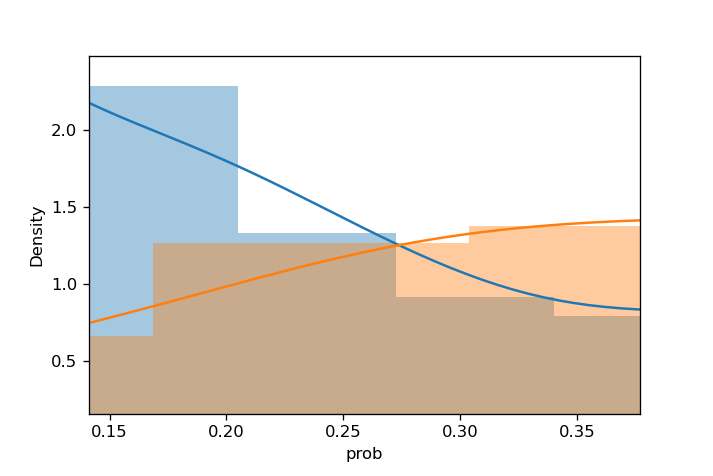

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [149]:
sns.distplot( train_pf.loc[ train_pf.actual == 0, 'prob' ] )
sns.distplot( train_pf.loc[ train_pf.actual == 1, 'prob' ] )
plt.show()